In [2]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from pyattck import Attck
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import networkx as nx
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

from pyvis.network import Network
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
attck = Attck()
edges = set()

for actor in attck.enterprise.actors[:5]:
    edge_i = [x.id for x in actor.techniques]
    edge_j = [x.id for x in actor.techniques]
    for technique_i in edge_i:
        for technique_j in edge_j:
            if technique_j != technique_i:
                edges.add((technique_i, technique_j))

edges = list(edges)
len(edges)

538

In [4]:
df = pd.DataFrame(
    edges,
    columns=['source', 'target']
)
df.head()

,source,target
0,T1583.001,T1588.001
1,T1049,T1007
2,T1021.001,T1588.001
3,T1114.001,T1021.001
4,T1036.005,T1114.001


In [5]:
G = nx.from_pandas_edgelist(df, "source", "target", create_using=nx.Graph())

In [6]:
def plot_nodes(word_list):
    X = model[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()

In [7]:
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [8]:
# get list of all nodes from the graph
all_nodes = list(G.nodes())

random_walks = []
for n in tqdm(all_nodes):
    random_walks.append(get_randomwalk(n,40))
        
# count of sequences
len(random_walks)
random_walks

100%|████████████████████| 34/34 [00:00<00:00, 2823.66it/s]


[['T1583.001',
  'T1036.005',
  'T1114.001',
  'T1566.002',
  'T1059.003',
  'T1057',
  'T1003.001',
  'T1114.002',
  'T1005',
  'T1550.002',
  'T1021.001',
  'T1016',
  'T1588.001',
  'T1585.002',
  'T1087.001',
  'T1135',
  'T1049',
  'T1560.001',
  'T1566.001',
  'T1119',
  'T1584.001',
  'T1007'],
 ['T1588.001',
  'T1021.001',
  'T1087.001',
  'T1550.002',
  'T1003.001',
  'T1036.005',
  'T1119',
  'T1584.001',
  'T1114.001',
  'T1007',
  'T1583.001',
  'T1566.001',
  'T1203',
  'T1204.002',
  'T1571',
  'T1036.004',
  'T1059.005',
  'T1027',
  'T1105',
  'T1053.005'],
 ['T1049',
  'T1057',
  'T1585.002',
  'T1560.001',
  'T1566.001',
  'T1053.005',
  'T1036.004',
  'T1105',
  'T1204.002',
  'T1027',
  'T1059.005',
  'T1571'],
 ['T1007',
  'T1588.001',
  'T1036.005',
  'T1119',
  'T1016',
  'T1560.001',
  'T1135',
  'T1057',
  'T1003.001',
  'T1566.001',
  'T1568.003',
  'T1203',
  'T1204.002',
  'T1102.002'],
 ['T1021.001',
  'T1550.002',
  'T1119',
  'T1057',
  'T1003.001',
  'T1

In [9]:
# train skip-gram (word2vec) model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(3047, 14420)

In [10]:
prediction = model.similar_by_word('T1567')
prediction

KeyError: "word 'T1567' not in vocabulary"

In [282]:
sim_results = [x for x,y in prediction]
sim_results

['T1584.003',
 'T1546.013',
 'T1585.002',
 'T1567.002',
 'T1213',
 'T1003.003',
 'T1547.004',
 'T1007',
 'T1069.002',
 'T1134.002']

In [270]:
matriclist = []


for item in sim_results:
    for tactic in attck.enterprise.tactics:
        for technique in tactic.techniques:
            if technique.id in item:
                matric = {
                  "techniqueID": "",
                  "tactic": "",
                  "score": 1,
                  "color": "",
                  "comment": "",
                  "enabled": "true",
                  "metadata": [],
                  "showSubtechniques": "true"
                }
                tacticname = tactic.name.lower()
                tacticname = tacticname.replace(' ', '-')
                matric["tactic"] = tacticname
                
                matric["techniqueID"] = technique.id
                matriclist.append(matric)
matriclist

[{'techniqueID': 'T1584',
  'tactic': 'resource-development',
  'score': 1,
  'color': '',
  'comment': '',
  'enabled': 'true',
  'metadata': [],
  'showSubtechniques': 'true'},
 {'techniqueID': 'T1584.006',
  'tactic': 'resource-development',
  'score': 1,
  'color': '',
  'comment': '',
  'enabled': 'true',
  'metadata': [],
  'showSubtechniques': 'true'},
 {'techniqueID': 'T1201',
  'tactic': 'discovery',
  'score': 1,
  'color': '',
  'comment': '',
  'enabled': 'true',
  'metadata': [],
  'showSubtechniques': 'true'},
 {'techniqueID': 'T1584',
  'tactic': 'resource-development',
  'score': 1,
  'color': '',
  'comment': '',
  'enabled': 'true',
  'metadata': [],
  'showSubtechniques': 'true'},
 {'techniqueID': 'T1584.003',
  'tactic': 'resource-development',
  'score': 1,
  'color': '',
  'comment': '',
  'enabled': 'true',
  'metadata': [],
  'showSubtechniques': 'true'},
 {'techniqueID': 'T1588.001',
  'tactic': 'resource-development',
  'score': 1,
  'color': '',
  'comment': 

In [272]:
actortechnic = []
for actor in attck.enterprise.actors:
    techlist = []
    for technique in actor.techniques:
        techlist.append(technique.id)
    actortechnic.append(techlist)

In [273]:
actortechnic[7]

['T1001.001',
 'T1091',
 'T1114.002',
 'T1105',
 'T1559.002',
 'T1564.001',
 'T1070.006',
 'T1566.002',
 'T1120',
 'T1113',
 'T1083',
 'T1070.001',
 'T1204.002',
 'T1546.015',
 'T1566.001',
 'T1213.002',
 'T1037.001',
 'T1040',
 'T1542.003',
 'T1068',
 'T1211',
 'T1119',
 'T1134.001',
 'T1025',
 'T1074.001',
 'T1550.002',
 'T1078',
 'T1199',
 'T1218.011',
 'T1071.003',
 'T1059.001',
 'T1092',
 'T1005',
 'T1003.001',
 'T1070.004',
 'T1027',
 'T1014',
 'T1560',
 'T1059.003',
 'T1090.002',
 'T1057',
 'T1210',
 'T1056.001',
 'T1140',
 'T1203',
 'T1137.002',
 'T1221',
 'T1573.001',
 'T1043',
 'T1550.001',
 'T1528',
 'T1564.003',
 'T1071.001',
 'T1003',
 'T1110.003',
 'T1110.001',
 'T1498',
 'T1190',
 'T1583.001']

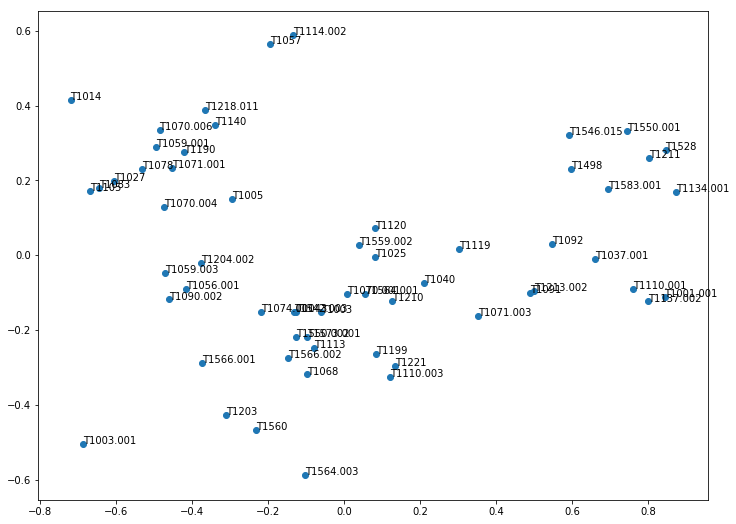

In [274]:
plot_nodes(actortechnic[7])

In [275]:
similar = model.similar_by_word('T1105')

In [276]:
similar = [x for x, y in similar]
similar

['T1587.002',
 'T1195',
 'T1071.001',
 'T1565.002',
 'T1059.006',
 'T1546.009',
 'T1565.003',
 'T1176',
 'T1112',
 'T1059.003']

# Stellargraph

In [291]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

nt = Network('1000px', '2000px')
nt.show_buttons(filter_=['physics'])
nt.from_nx(G)
nt.show('nx.html')

In [214]:
Graph = StellarGraph.from_networkx(G)
rw = BiasedRandomWalk(Graph)

random_walks = rw.run(
    nodes=list(Graph.nodes()),  # root nodes
    length=100,  # maximum length of a random walk (how deep to go)
    n=10,  # number of random walks per root node (samples per node)
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=1.0,  # Defines (unormalised) probability, 1/q, for moving away from source node (2 = half the chance, 1 is full )
    weighted=False,  # since we are interested in unweighted walks
    seed=42,  # for reproducibility
)
print("Number of random walks: {}".format(len(random_walks)))

Number of random walks: 2930


In [215]:
model = Word2Vec(random_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [216]:
predict = "T1571"
similar = model.similar_by_word(predict)
print(similar)
[(x, y) for x,y in similar if "T" in x]

[('T1565.003', 0.9879963994026184), ('T1065', 0.9871951937675476), ('T1547.001', 0.9864795207977295), ('T1547.009', 0.9855067729949951), ('T1565.001', 0.9854599237442017), ('T1041', 0.9852985739707947), ('T1110.002', 0.9823161959648132), ('T1587.002', 0.9810513257980347), ('T1098', 0.9807142615318298), ('T1565.002', 0.9802106022834778)]


[('T1565.003', 0.9879963994026184),
 ('T1065', 0.9871951937675476),
 ('T1547.001', 0.9864795207977295),
 ('T1547.009', 0.9855067729949951),
 ('T1565.001', 0.9854599237442017),
 ('T1041', 0.9852985739707947),
 ('T1110.002', 0.9823161959648132),
 ('T1587.002', 0.9810513257980347),
 ('T1098', 0.9807142615318298),
 ('T1565.002', 0.9802106022834778)]

In [63]:
simnodes = [x for x,y in similar] + [predict]
H = G.subgraph(simnodes)
nt = Network('1000px', '2000px')
nt.show_buttons(filter_=['physics'])
nt.from_nx(H)
nt.show('nx.html')